# Import from VAE, utils, getdata

In [63]:
from getdata import get_tickers_data, get_CAC40_tickers, get_returns
from denseVAE import denseVAE
from convVAE import convVAE
from utils import train_vae, SequenceDataset, plot_convergences, plot_convergence, kendall_evaluation

from torchinfo import summary

import torch
import torch.optim as optim
from torch.utils.data import  DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

seed = 42

In [64]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler):
        self.scaler = scaler

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X_df):
        self.idx = X_df.index
        self.col = X_df.columns
        res = self.scaler.transform(X_df)
        res = pd.DataFrame(res,index=self.idx,columns=self.col)

        return res
    
    def inverse_transform(self, X_df, prior=False):
        if not prior:
            if type(X_df) == np.ndarray:
                idx = self.idx
                col = self.col
            else:
                idx = X_df.index
                col = X_df.columns
            res = self.scaler.inverse_transform(X_df)
            res = pd.DataFrame(res,index=idx,columns=col)
        else:
            res = self.scaler.inverse_transform(X_df)
        return res

# Dataset setup

In [65]:
internet = True

#######################################
# BIVARIATE DATASET
#######################################
nb_stocks=2
sequence_size=2**9

if internet:
    # Define the dataset with sequences of fixed size
    # Set the window for returns extraction
    start_date = '2017-01-02'
    end_date = '2023-02-08'
    # load the returns for a certain number of stocks
    full_train_data = get_tickers_data(get_CAC40_tickers(nb_stocks), start_date, end_date, returns_only=False)
else:
    full_train_data = pd.read_csv("temp_stocks.csv")
    full_train_data = full_train_data.set_index(full_train_data.columns[0], drop=True).iloc[:,:nb_stocks]

bivariate_scaler = Scaler(MinMaxScaler())
bivariate_data = bivariate_scaler.fit_transform(full_train_data)

# Set the dataloader
torch.manual_seed(seed)
sequences = SequenceDataset(bivariate_data, sequence_length=sequence_size)
sequences_dataloader = DataLoader(sequences, batch_size=50, shuffle=True)


#######################################
# UNIVARIATE DATASET
#######################################

if internet:
    # Define the dataset with sequences of fixed size
    # Set the window for returns extraction
    start_date = '2017-01-02'
    end_date = '2023-02-08'
    # load the returns for a certain number of stocks
    full_train_data_uni = get_tickers_data("^GSPC", start_date, end_date, returns_only=False)
else:
    full_train_data_uni = pd.read_csv("temp_stocks.csv")
    full_train_data_uni = univariate_data.set_index(full_train_data_uni.columns[0], drop=True).iloc[:,:nb_stocks]

univariate_scaler = Scaler(MinMaxScaler())
univariate_data = univariate_scaler.fit_transform(full_train_data_uni)

# Set the dataloader
torch.manual_seed(seed)
univariate_sequences = SequenceDataset(univariate_data, sequence_length=sequence_size)
univariate_sequences_dataloader = DataLoader(univariate_sequences, batch_size=50, shuffle=True)


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed


In [66]:
full_train_data_uni

Close
2017-01-03  2257.830078
2017-01-04  2270.750000
2017-01-05  2269.000000
2017-01-06  2276.979980
2017-01-09  2268.899902
...                 ...
2023-02-01  4119.209961
2023-02-02  4179.759766
2023-02-03  4136.479980
2023-02-06  4111.080078
2023-02-07  4164.000000

[1591 rows x 1 columns]

In [67]:
SPreturns = get_tickers_data("^GSPC", start_date, end_date, returns_only=True)
stocksreturn = get_tickers_data(get_CAC40_tickers(nb_stocks), start_date, end_date, returns_only=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


In [68]:
def plot_acf_pacf(serie, title="S&P 500 Returns"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
    plot_acf(serie, lags=21, ax=ax1, zero=False)
    ax1.set_ylabel("Autocorrelation")
    ax1.set_title(f"{title} Autocorrelation")
    plot_pacf(serie, lags=21, ax=ax2, zero=False)
    ax2.set_ylabel("Partial Autocorrelation")
    ax2.set_title(f"{title} Partial Autocorrelation")
    fig.text(0.53, -0.01, "Lag", ha="center", va="center", fontsize=12)
    plt.tight_layout()
    plt.show()

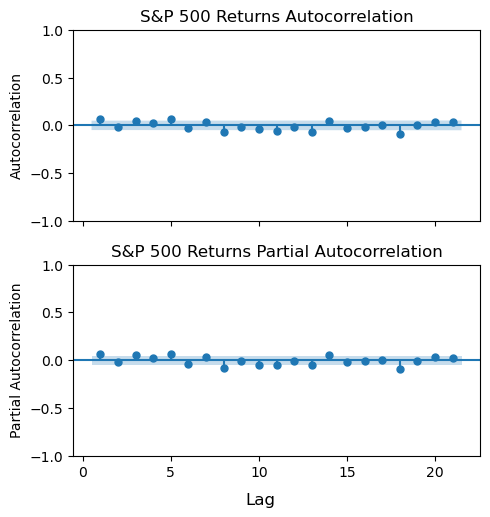

In [69]:
plot_acf_pacf(stocksreturn.iloc[:,1])

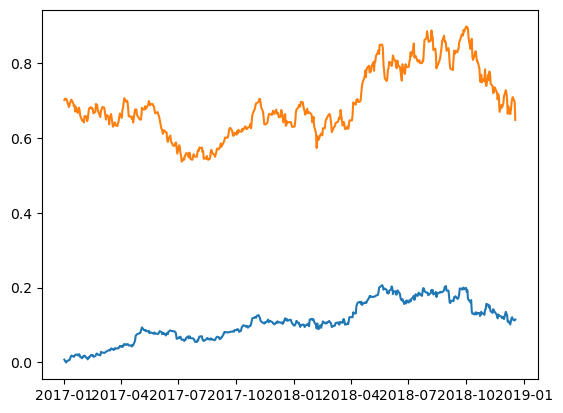

In [70]:
plt.plot(bivariate_data[:sequence_size])
plt.show()

# Dense VAE univariate

We first tried with the most basic model : that's equals encoder and decoder, with 3 layers : [input, 250, 100]
Learning rate at 1e-5, no gradient clipping, no annealing function for KLD, and no regularization
We were working on log-returns. 


After many attemps, the model did not converge. Results after 100 epochs could have been considered, but they were deteriorating quickly above. 

The output was increasingly concentrated around the average (which was often 0, or 0.5 with minmax scaling) so we presumed the variance from the latent space became closer and closer to 0 too. After investigation, we were right. The latent space was unable to model anything from the data. 

One problem could have been the loss impact on parameters update. We found out that this problem has been identified by Bowman in "Generating Sentences from a Continuous Space" (https://arxiv.org/pdf/1511.06349.pdf) as an illness for such model. It could be resolved with the help of an annealing function that weights the KLD impact : low (close to 0) at the beginning of the training, high at the end, to finally really optimize on the ELBO.

Results were better but still not exploitable. We ran our algorithms on the prices directly, and get very good results as you can see below. We refined the methodology by changing the structure of the networks, adding regularization, annealing function on KL term, and gradient clipping. 

In [71]:
# Define the VAE model to train/test
z_dim=10
n_epochs = 300
lr = 1e-3
encode_dim = [400, 200, 50]
decode_dim = [50, 200, 400]

uni_dense_vae_model = denseVAE(encod_hidden_layer_sizes=encode_dim,
                    decod_hidden_layer_sizes=decode_dim,
                    sequence_size=sequence_size, 
                    nb_features=1, 
                    z_dim=z_dim,
                    use_GPU=True)

uni_dense_vae_model.optimizer = optim.Adam(uni_dense_vae_model.parameters(), lr=lr, weight_decay=0.0)

summary(uni_dense_vae_model, input_size=(1, sequence_size, 1))

Layer (type:depth-idx)                   Output Shape              Param #
denseVAE                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 50]                   --
│    └─Flatten: 2-1                      [1, 512]                  --
│    └─Linear: 2-2                       [1, 400]                  205,200
│    └─Dropout: 2-3                      [1, 400]                  --
│    └─ReLU: 2-4                         [1, 400]                  --
│    └─Linear: 2-5                       [1, 200]                  80,200
│    └─Dropout: 2-6                      [1, 200]                  --
│    └─ReLU: 2-7                         [1, 200]                  --
│    └─Linear: 2-8                       [1, 50]                   10,050
│    └─ReLU: 2-9                         [1, 50]                   --
├─Linear: 1-2                            [1, 10]                   510
├─Linear: 1-3                            [1, 10]                   510


====> Epoch: 0 Av. loss: 106.1093 Av. KLD: 2.8983 Av. rec: 5276.4576


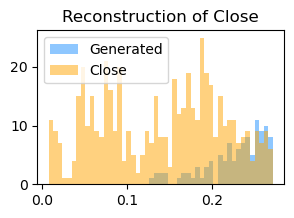

====> Epoch: 20 Av. loss: 7.5035 Av. KLD: 31.1343 Av. rec: 360.8659


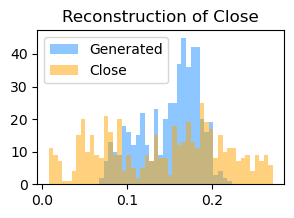

====> Epoch: 40 Av. loss: 6.0789 Av. KLD: 31.8622 Av. rec: 286.0783


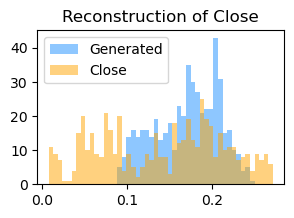

====> Epoch: 60 Av. loss: 5.2733 Av. KLD: 28.6157 Av. rec: 240.9689


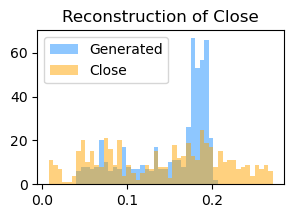

====> Epoch: 80 Av. loss: 4.9408 Av. KLD: 21.8564 Av. rec: 224.4496


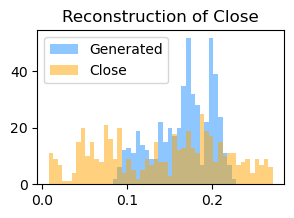

====> Epoch: 100 Av. loss: 3.9689 Av. KLD: 16.1903 Av. rec: 178.1005


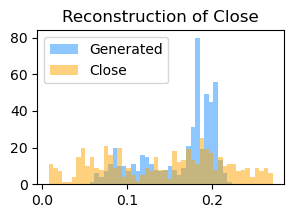

====> Epoch: 120 Av. loss: 3.5242 Av. KLD: 15.4458 Av. rec: 157.5367


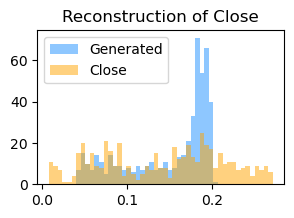

====> Epoch: 140 Av. loss: 3.2535 Av. KLD: 15.2460 Av. rec: 144.3074


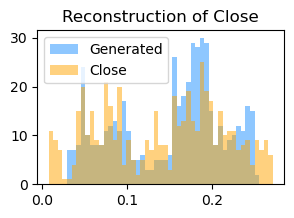

====> Epoch: 160 Av. loss: 2.7007 Av. KLD: 14.2013 Av. rec: 118.1601


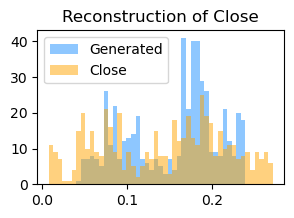

====> Epoch: 180 Av. loss: 2.3059 Av. KLD: 12.8054 Av. rec: 100.4709


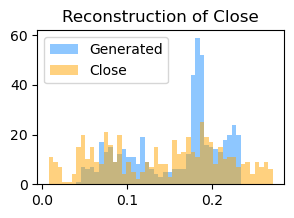

====> Epoch: 200 Av. loss: 2.3108 Av. KLD: 11.5510 Av. rec: 101.8513


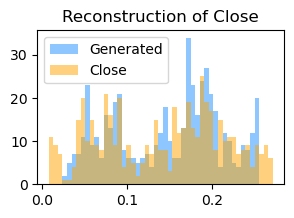

====> Epoch: 220 Av. loss: 2.1219 Av. KLD: 11.5086 Av. rec: 91.9906


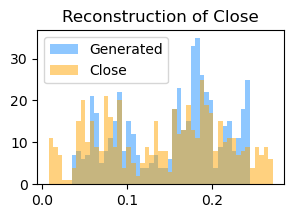

====> Epoch: 240 Av. loss: 2.1186 Av. KLD: 11.2348 Av. rec: 92.2974


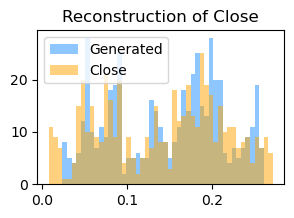

====> Epoch: 260 Av. loss: 1.9466 Av. KLD: 11.1363 Av. rec: 84.2376


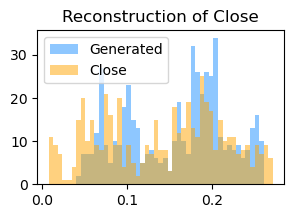

====> Epoch: 280 Av. loss: 1.8617 Av. KLD: 9.4719 Av. rec: 81.9552


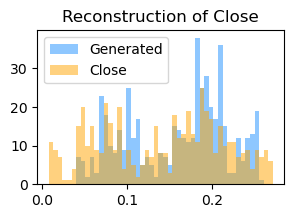

====> Epoch: 300 Av. loss: 1.8881 Av. KLD: 9.8476 Av. rec: 82.4874


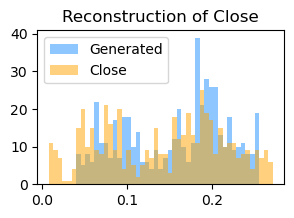

In [72]:
# training function
list_z_mu, list_z_logvar, list_ad, _, list_KLD, list_rec, list_weights, all_reconstructions = train_vae(vae_model=uni_dense_vae_model, 
                                                                                                        sequences_dataloader=univariate_sequences_dataloader, 
                                                                                                        n_epochs=n_epochs, 
                                                                                                        eval_data=univariate_data[:sequence_size], 
                                                                                                        grad_norm=1,
                                                                                                        k=0.0025,
                                                                                                        anneal_function="linear")

In [75]:
def plot_lists(lists, names, log_names=["Reconstruction cost"]):
    n_rows = 2
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4))
    # Loop through each list and plot the data
    for i, ax in enumerate(axes.flat):
        if i < len(lists):
            ax.plot(lists[i])
            ax.set_title(names[i])
            ax.set_xlabel("Epochs")
            if i % n_cols == 0:
                ax.set_ylabel("Value")
            if names[i] in log_names:
                ax.set_yscale("log")
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
def simul_with_VAE(model, scaler, nb_simul=100, plot_one_diffusion=True):
    """ Return the nb_simul sample of prices
    with the associated cumulative returns
    """
    samples_prices = []
    samples_returns = []
    samples_cumsum_returns = []
    
    # Use the model to generate nb_simul samples
    samples = model.prior_sample(nb_simul).squeeze().cpu().detach().numpy()
    # Get prices by inverse transform for each sample
    for sample in samples:
        # Inverse the sample
        if sample.ndim==1:
            sample = sample[:, None]
            
        sample_inverse = scaler.inverse_transform(sample, prior=True)
        samples_prices.append(sample_inverse)

        # Get the returns related to these series of prices
        sample_returns = np.diff(sample_inverse, axis=0) / sample_inverse[:-1]
        samples_returns.append(sample_returns)
        
        # Get the cumulated sum returms (usual monte carlo representation)
        sample_returns_cumsum = sample_returns.cumsum(axis=0)
        samples_cumsum_returns.append(sample_returns_cumsum)
        
    if plot_one_diffusion:
        plt.plot(np.asarray(samples_cumsum_returns)[:,:,0].T)
        plt.title(f"Diffusion for {scaler.col[0]} : {nb_simul} simulations")
        plt.show()
    return np.asarray(samples_prices), np.asarray(samples_returns), np.asarray(samples_cumsum_returns)

from scipy.stats import anderson_ksamp, kendalltau
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_reconstruction(reconstructed_data_np, to_reconstruct, scaler):
    n_plots = to_reconstruct.shape[1]
    cols = 2
    rows = n_plots // cols + (n_plots % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(8, 4), constrained_layout=True)
    axes = axes.flatten()

    # Initialize empty lists to store handles and labels
    handles, labels = [], []

    for i in range(n_plots):
        line1, = axes[i].plot(reconstructed_data_np[:, i], label="Reconstructed")
        line2, = axes[i].plot(to_reconstruct[:, i], label="Original")
        axes[i].set_title(scaler.col[i])

        # Collect handles and labels
        h, l = axes[i].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    # Hide any unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)

    # Create a single legend for the entire figure
    fig.legend(handles[:2], labels[:2], loc='upper center', ncol=2)

    plt.show()

def get_metrics(vae_model, eval_data, scaler, plot_rec=True):
    
    # Define all the metrics 
    MAE = 0.0
    MAPE = 0.0 
    RMSE = 0.0 
    AD = 0.0 
    KE = 0.0 
    
    # Set the data shape and type
    if isinstance(eval_data, pd.DataFrame):
        to_reconstruct = torch.tensor(eval_data.values[None,:,:]).to(torch.float32)
    else:
        to_reconstruct = torch.tensor(eval_data[None,:,:]).to(torch.float32)
    
    # Reconstructe the evaluation data 
    reconstructed_data = vae_model.reconstructe(to_reconstruct)
    
    # Convert tensors to numpy arrays
    if reconstructed_data.ndim==4:
        reconstructed_data_np = reconstructed_data.detach().cpu().numpy().squeeze(0).squeeze(0)
        to_reconstruct = to_reconstruct.squeeze(0).squeeze(0).numpy()
    else:
        reconstructed_data_np = reconstructed_data.detach().cpu().numpy().squeeze(0)
        to_reconstruct = to_reconstruct.squeeze(0).numpy()
        
    if plot_rec:
        plot_reconstruction(reconstructed_data_np, to_reconstruct, scaler)
        
    def mae(pred, y):
        error = pred - y
        return np.abs(error).mean()

    def mape(pred, y):
        error = pred - y
        return np.abs(error / y).mean() * 100

    def rmse(pred, y):
        error = pred - y
        return np.sqrt(np.square(error).mean())
    
    MAPE = mape(to_reconstruct, reconstructed_data_np)
    RMSE = rmse(to_reconstruct, reconstructed_data_np)
    MAE = mean_absolute_error(to_reconstruct, reconstructed_data_np)
    AD = anderson_ksamp([to_reconstruct.flatten(), reconstructed_data_np.flatten()]).statistic
    if to_reconstruct.shape[1]>=2:
        KE = kendall_evaluation(to_reconstruct, reconstructed_data_np)

    return MAE, MAPE, RMSE, AD, KE, to_reconstruct,reconstructed_data_np

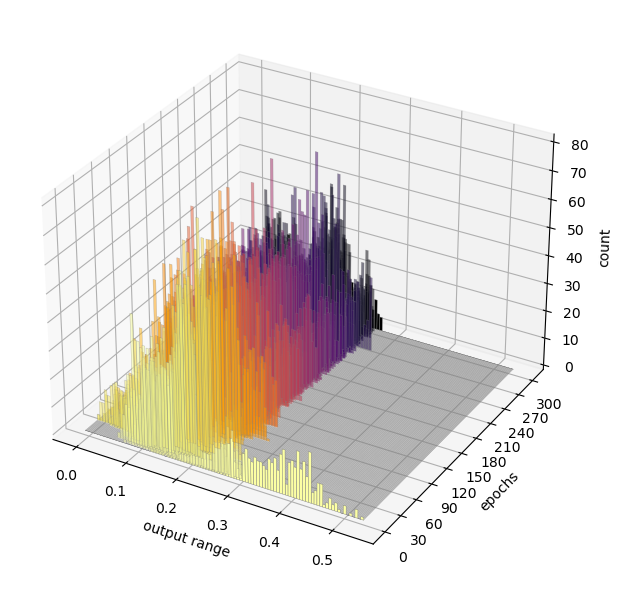

In [77]:
plot_convergence(np.asarray(all_reconstructions), univariate_data[:sequence_size].squeeze(), save=False, model="dense")

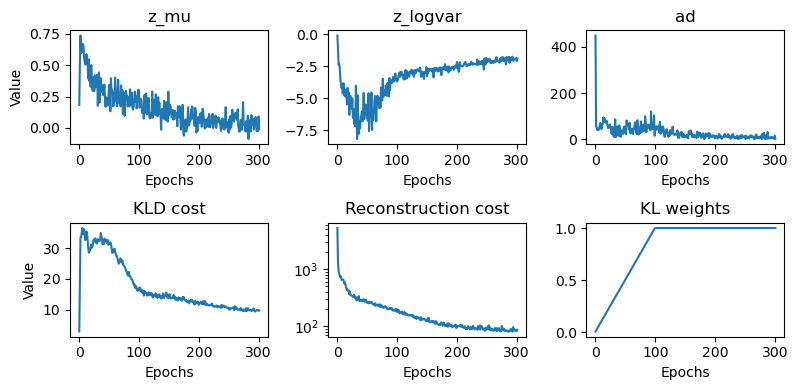

In [76]:
all_lists = [list_z_mu, list_z_logvar, list_ad, list_KLD, list_rec, list_weights]
all_names = ["z_mu", "z_logvar", "ad", "KLD cost", "Reconstruction cost", "KL weights"]
plot_lists(all_lists, all_names)

In [77]:
uni_dense_vae_model.eval()

denseVAE(
  (encode_main): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=400, bias=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=200, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=200, out_features=50, bias=True)
    (8): ReLU()
  )
  (encode_mu): Linear(in_features=50, out_features=10, bias=True)
  (encode_log_var): Linear(in_features=50, out_features=10, bias=True)
  (decode_main): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=200, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=200, out_features=400, bias=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=400, out_features=512, bias=True)
  )
)

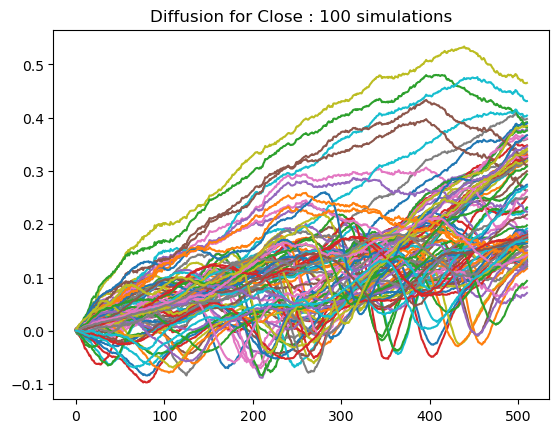

In [78]:
samples_prices, samples_returns, samples_cumsum_returns = simul_with_VAE(uni_dense_vae_model, univariate_scaler)

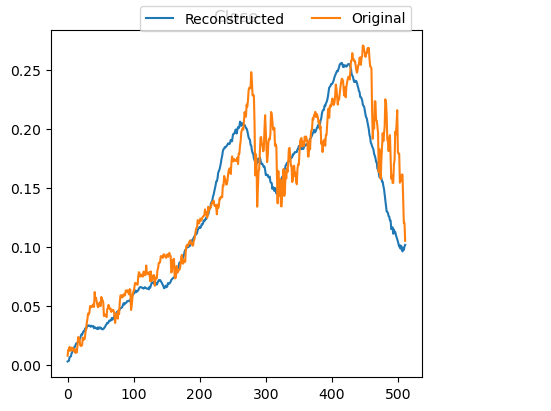

In [81]:
MAE_dense_uni, MAPE_dense_uni, RMSE_dense_uni, AD_dense_uni, KE_dense_uni,_,_ = get_metrics(uni_dense_vae_model, 
                                                                                        univariate_data[:sequence_size], 
                                                                                        univariate_scaler,
                                                                                        plot_rec=True)

# Dense VAE bivariate

## Setup

In [82]:
# Define the VAE model to train/test
z_dim=10
n_epochs = 300
lr = 1e-3
encode_dim = [500,250,50]
decode_dim = [50,250,500]

bi_dense_vae_model = denseVAE(encod_hidden_layer_sizes=encode_dim,
                    decod_hidden_layer_sizes=decode_dim,
                    sequence_size=sequence_size, 
                    nb_features=bivariate_data.shape[1], 
                    z_dim=z_dim,
                    use_GPU=True)

bi_dense_vae_model.optimizer = optim.Adam(bi_dense_vae_model.parameters(), lr=lr, weight_decay=0.001)

summary(bi_dense_vae_model, input_size=(1, sequence_size, 2))

Layer (type:depth-idx)                   Output Shape              Param #
denseVAE                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 50]                   --
│    └─Flatten: 2-1                      [1, 1024]                 --
│    └─Linear: 2-2                       [1, 500]                  512,500
│    └─Dropout: 2-3                      [1, 500]                  --
│    └─ReLU: 2-4                         [1, 500]                  --
│    └─Linear: 2-5                       [1, 250]                  125,250
│    └─Dropout: 2-6                      [1, 250]                  --
│    └─ReLU: 2-7                         [1, 250]                  --
│    └─Linear: 2-8                       [1, 50]                   12,550
│    └─ReLU: 2-9                         [1, 50]                   --
├─Linear: 1-2                            [1, 10]                   510
├─Linear: 1-3                            [1, 10]                   510

====> Epoch: 0 Av. loss: 207.7583 Av. KLD: 0.8898 Av. rec: 10324.6957


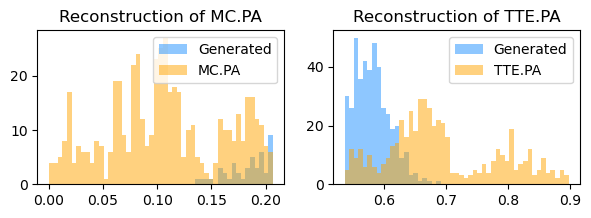

====> Epoch: 20 Av. loss: 9.5572 Av. KLD: 51.1224 Av. rec: 469.2111


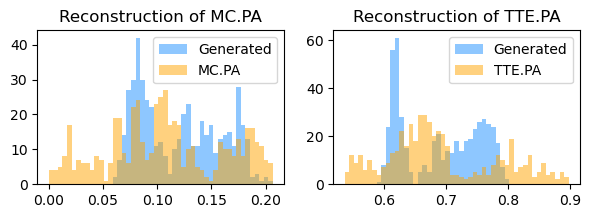

====> Epoch: 40 Av. loss: 7.3651 Av. KLD: 47.9325 Av. rec: 359.9027


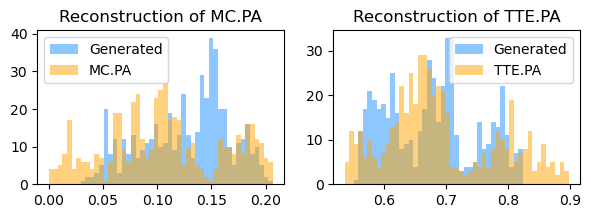

====> Epoch: 60 Av. loss: 6.0860 Av. KLD: 50.0494 Av. rec: 293.3449


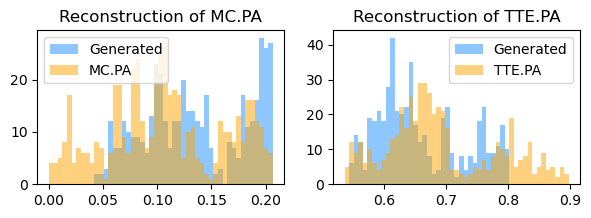

====> Epoch: 80 Av. loss: 5.6823 Av. KLD: 47.1323 Av. rec: 266.3949


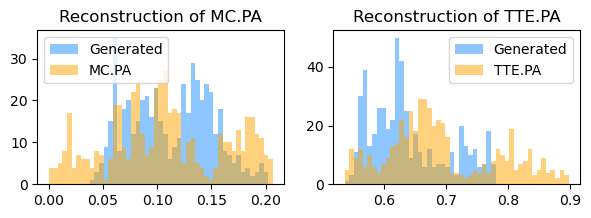

====> Epoch: 100 Av. loss: 5.8491 Av. KLD: 35.3359 Av. rec: 269.2909


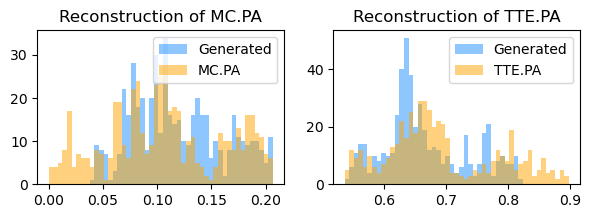

====> Epoch: 120 Av. loss: 5.1189 Av. KLD: 27.5929 Av. rec: 231.4898


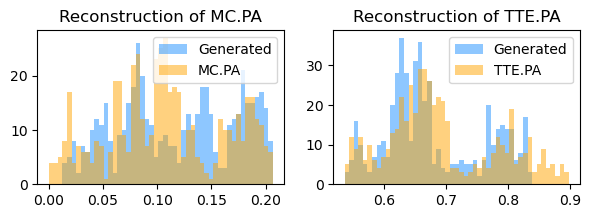

====> Epoch: 140 Av. loss: 5.0860 Av. KLD: 21.5881 Av. rec: 230.5658


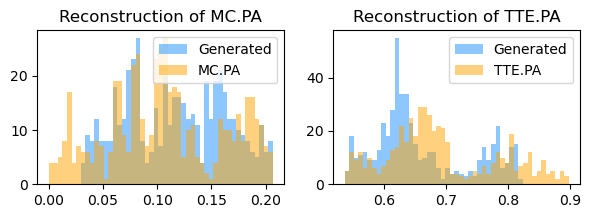

====> Epoch: 160 Av. loss: 4.7366 Av. KLD: 21.9697 Av. rec: 211.2755


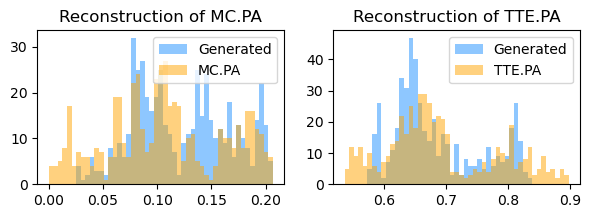

====> Epoch: 180 Av. loss: 4.5614 Av. KLD: 20.4691 Av. rec: 203.7612


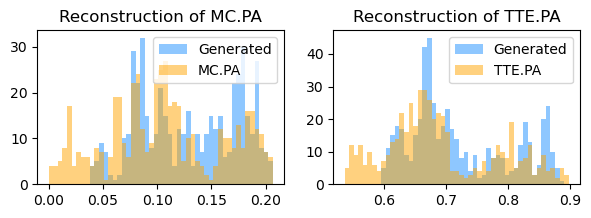

====> Epoch: 200 Av. loss: 4.5924 Av. KLD: 19.2860 Av. rec: 206.2266


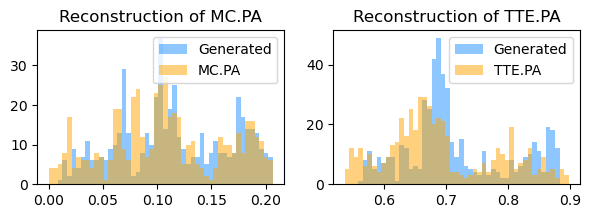

====> Epoch: 220 Av. loss: 4.4526 Av. KLD: 18.3162 Av. rec: 200.1534


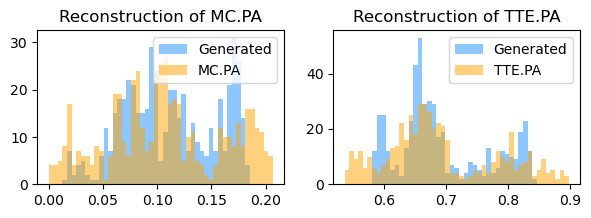

====> Epoch: 240 Av. loss: 4.2521 Av. KLD: 17.7503 Av. rec: 190.6727


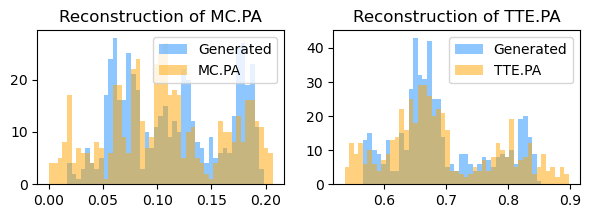

====> Epoch: 260 Av. loss: 4.1670 Av. KLD: 17.8799 Av. rec: 186.3314


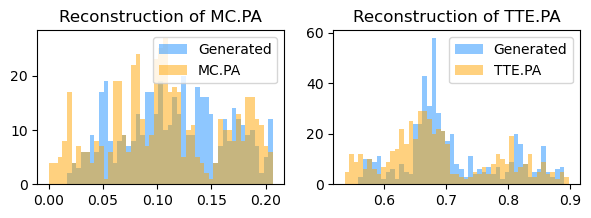

====> Epoch: 280 Av. loss: 4.1013 Av. KLD: 17.0142 Av. rec: 184.1309


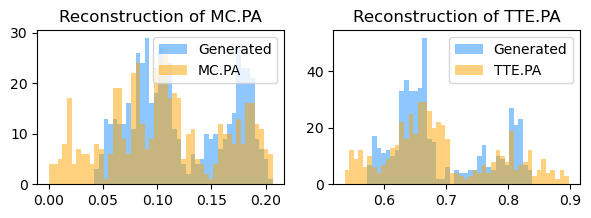

====> Epoch: 300 Av. loss: 4.0366 Av. KLD: 15.6988 Av. rec: 182.5030


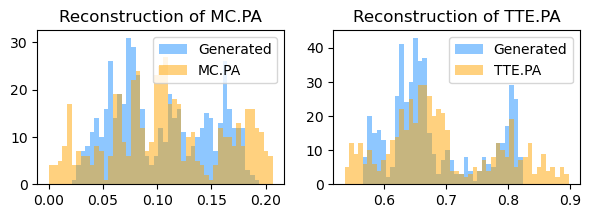

In [83]:
# training function
list_z_mu, list_z_logvar, list_ad, _, list_KLD, list_rec, list_weights, all_reconstructions = train_vae(vae_model=bi_dense_vae_model, 
                                                                                                        sequences_dataloader=sequences_dataloader, 
                                                                                                        n_epochs=n_epochs, 
                                                                                                        eval_data=bivariate_data[:sequence_size],
                                                                                                        grad_norm=1.0,
                                                                                                        k=0.0025,
                                                                                                        anneal_function="logistic")
    

## Diagnostic

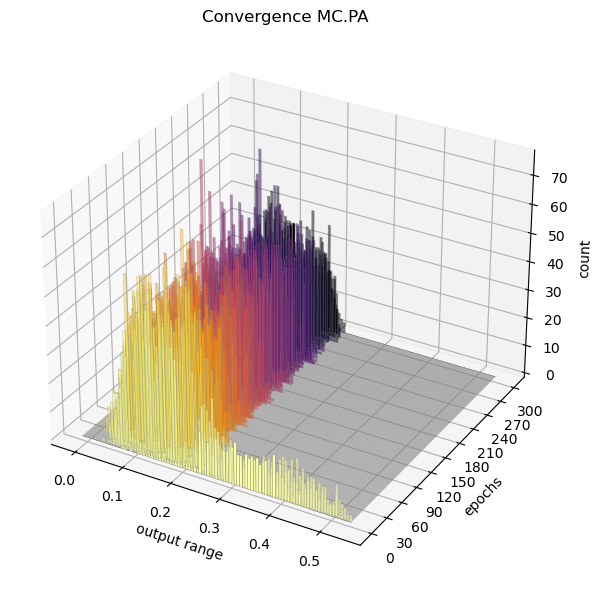

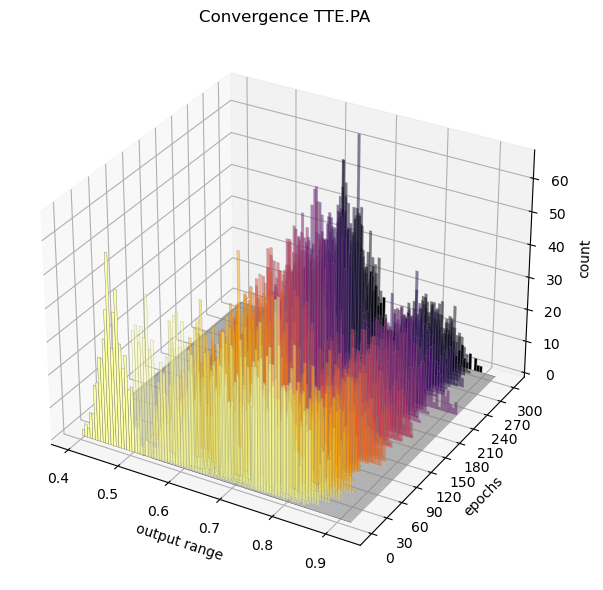

In [95]:
plot_convergences(all_reconstructions, bivariate_data[:sequence_size], save=False, model="dense")

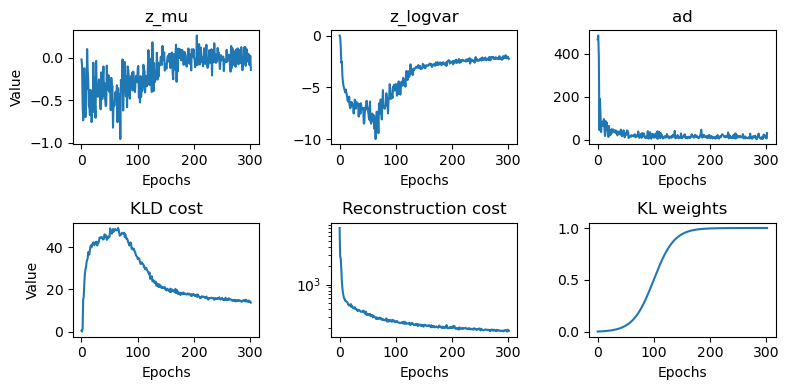

In [87]:
all_lists = [list_z_mu, list_z_logvar, list_ad, list_KLD, list_rec, list_weights]
all_names = ["z_mu", "z_logvar", "ad", "KLD cost", "Reconstruction cost", "KL weights"]
plot_lists(all_lists, all_names)

In [84]:
bi_dense_vae_model.eval()

denseVAE(
  (encode_main): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=500, bias=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=250, out_features=50, bias=True)
    (8): ReLU()
  )
  (encode_mu): Linear(in_features=50, out_features=10, bias=True)
  (encode_log_var): Linear(in_features=50, out_features=10, bias=True)
  (decode_main): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=250, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=250, out_features=500, bias=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=500, out_features=1024, bias=True)
  )
)

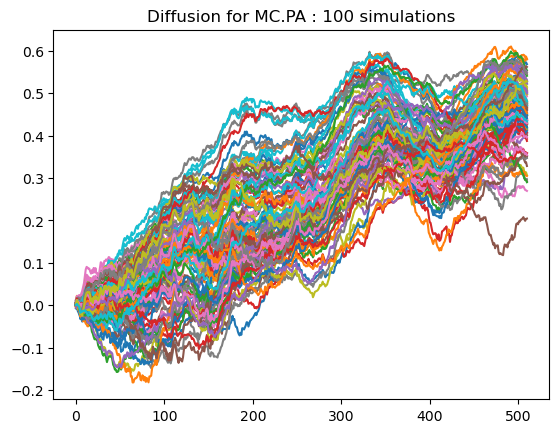

In [88]:
samples_prices, samples_returns, samples_cumsum_returns = simul_with_VAE(bi_dense_vae_model, bivariate_scaler)

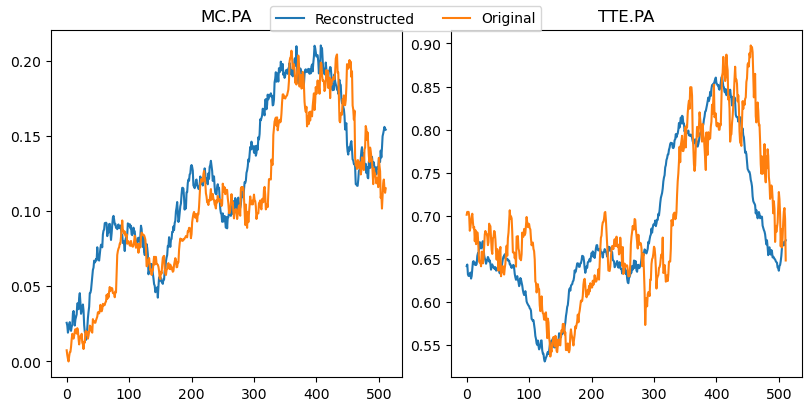

In [87]:
MAE_dense_bi, MAPE_dense_bi, RMSE_dense_bi, AD_dense_bi, KE_dense_bi, _, _ = get_metrics(bi_dense_vae_model, 
                                                                                    bivariate_data[:sequence_size], 
                                                                                    bivariate_scaler,
                                                                                    plot_rec=True)

# Convolutional VAE

In [26]:
# Define the VAE model to train/test
z_dim=10
n_epochs = 300
lr = 1e-3

encode_dim = list(np.asarray([1,25,50, 100]) * 1)

conv_vae_model = convVAE(encod_hidden_layer_sizes=encode_dim,
                    sequence_size=sequence_size, 
                    nb_features=bivariate_data.shape[1], 
                    z_dim=z_dim,
                   use_GPU=True)

conv_vae_model.optimizer = optim.Adam(conv_vae_model.parameters(), lr=lr, weight_decay=0.001)

summary(conv_vae_model, input_size=(1, 1, sequence_size, 2))

Layer (type:depth-idx)                   Output Shape              Param #
convVAE                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 100, 66, 2]           --
│    └─Conv2d: 2-1                       [1, 25, 257, 2]           250
│    └─BatchNorm2d: 2-2                  [1, 25, 257, 2]           50
│    └─LeakyReLU: 2-3                    [1, 25, 257, 2]           --
│    └─Conv2d: 2-4                       [1, 50, 130, 2]           11,300
│    └─BatchNorm2d: 2-5                  [1, 50, 130, 2]           100
│    └─LeakyReLU: 2-6                    [1, 50, 130, 2]           --
│    └─Conv2d: 2-7                       [1, 100, 66, 2]           45,100
│    └─BatchNorm2d: 2-8                  [1, 100, 66, 2]           200
│    └─LeakyReLU: 2-9                    [1, 100, 66, 2]           --
├─Sequential: 1-2                        [1, 100]                  --
│    └─Flatten: 2-10                     [1, 13200]                --
│   

====> Epoch: 0 Av. loss: 503.1868 Av. KLD: 280.7001 Av. rec: 24771.2820


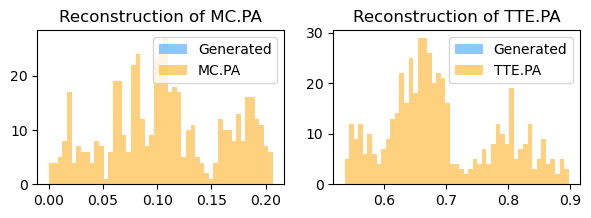

====> Epoch: 20 Av. loss: 2.6032 Av. KLD: 78.2018 Av. rec: 126.6857


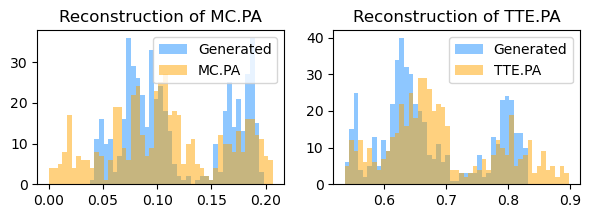

====> Epoch: 40 Av. loss: 1.6765 Av. KLD: 41.4357 Av. rec: 80.4465


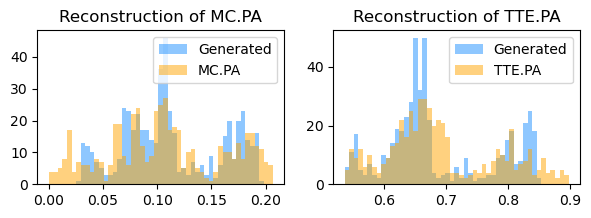

====> Epoch: 60 Av. loss: 1.2780 Av. KLD: 30.5825 Av. rec: 59.2929


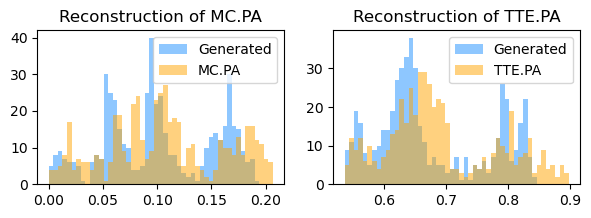

====> Epoch: 80 Av. loss: 1.2256 Av. KLD: 26.1444 Av. rec: 53.5855


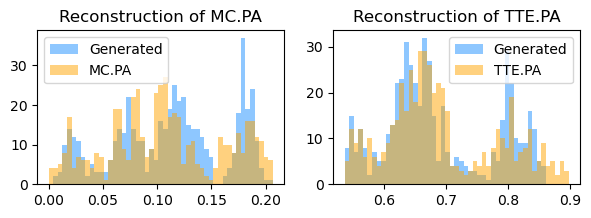

====> Epoch: 100 Av. loss: 1.1772 Av. KLD: 22.2941 Av. rec: 46.3482


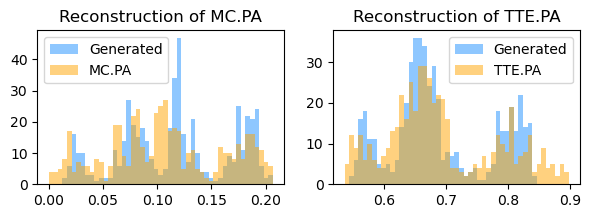

====> Epoch: 120 Av. loss: 1.2468 Av. KLD: 20.1988 Av. rec: 45.8577


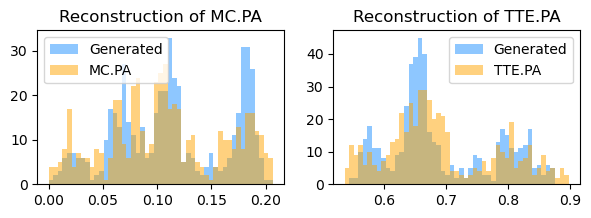

====> Epoch: 140 Av. loss: 1.3608 Av. KLD: 18.2624 Av. rec: 50.0674


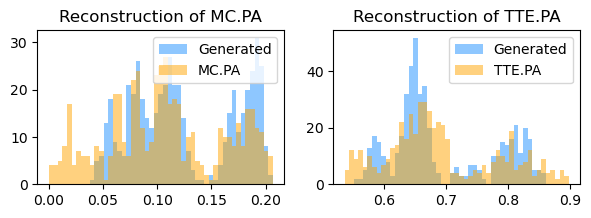

====> Epoch: 160 Av. loss: 1.3060 Av. KLD: 17.2823 Av. rec: 47.4714


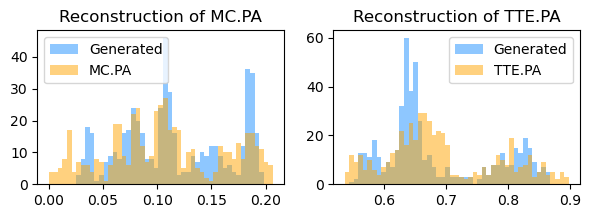

====> Epoch: 180 Av. loss: 1.1549 Av. KLD: 16.4559 Av. rec: 40.3042


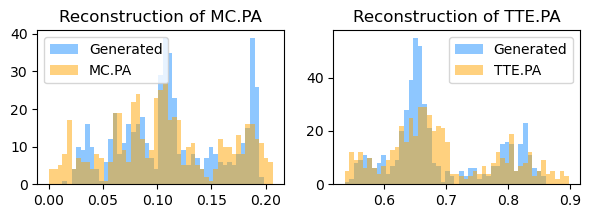

====> Epoch: 200 Av. loss: 1.1143 Av. KLD: 15.8151 Av. rec: 38.7763


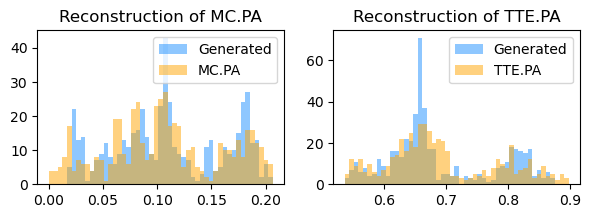

====> Epoch: 220 Av. loss: 1.1242 Av. KLD: 15.5603 Av. rec: 39.2979


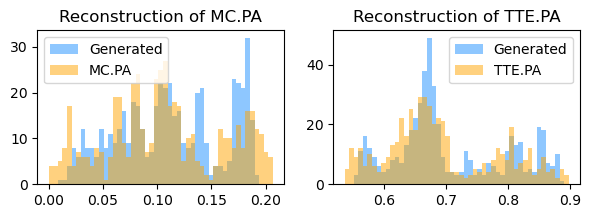

====> Epoch: 240 Av. loss: 1.1906 Av. KLD: 15.2210 Av. rec: 42.9228


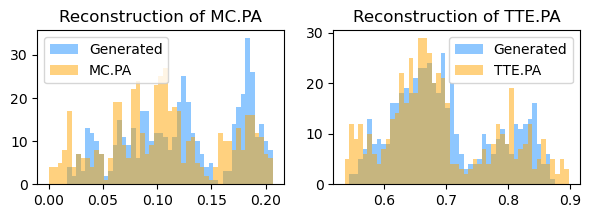

====> Epoch: 260 Av. loss: 1.0865 Av. KLD: 15.1519 Av. rec: 38.2056


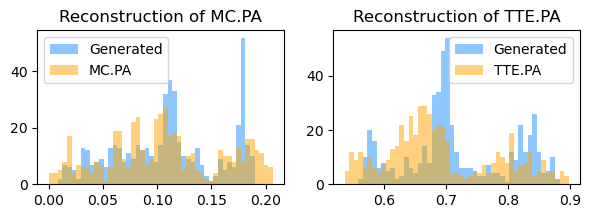

====> Epoch: 280 Av. loss: 1.0073 Av. KLD: 14.7887 Av. rec: 34.5282


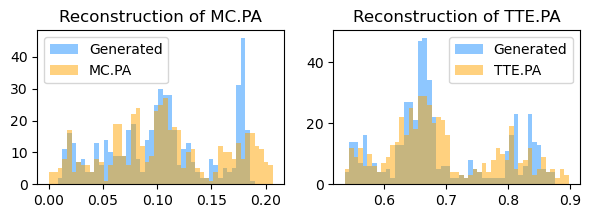

====> Epoch: 300 Av. loss: 0.9764 Av. KLD: 14.7447 Av. rec: 33.0712


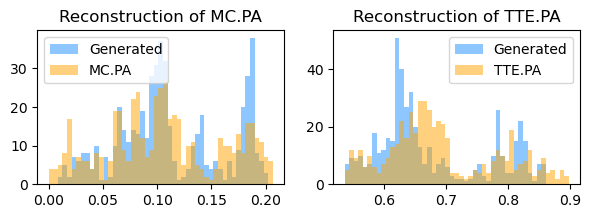

In [27]:
# training function
list_z_mu, list_z_logvar, list_ad, _, list_KLD, list_rec, list_weights, all_reconstructions = train_vae(vae_model=conv_vae_model, 
                                                                                                        sequences_dataloader=sequences_dataloader, 
                                                                                                        n_epochs=n_epochs, 
                                                                                                        eval_data=bivariate_data[:sequence_size], 
                                                                                                        grad_norm=1.0,
                                                                                                        dim4=True,
                                                                                                        k=0.0025,
                                                                                                        anneal_function="logistic")

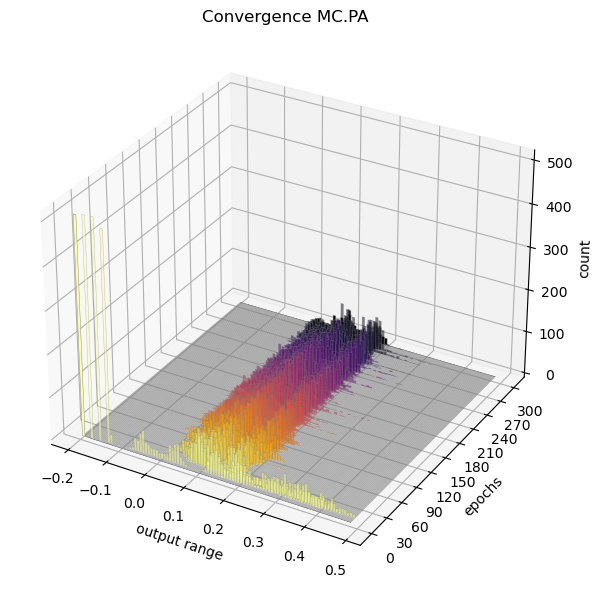

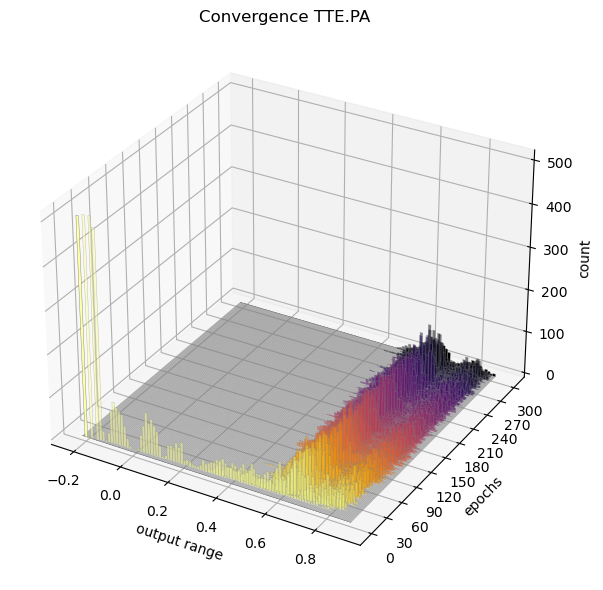

In [33]:
plot_convergences(all_reconstructions, bivariate_data[:sequence_size], save=False, model="conv")

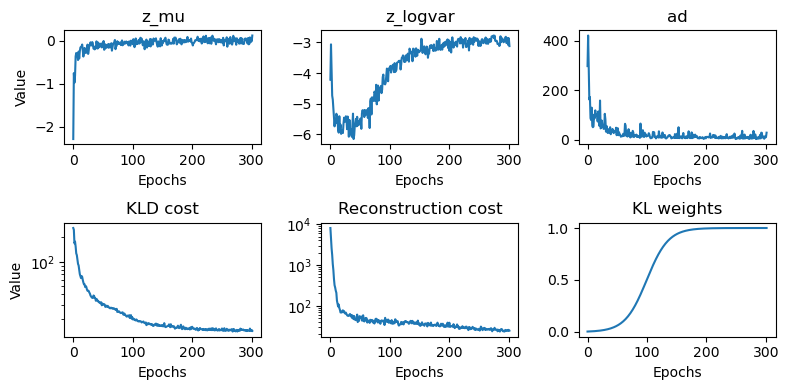

In [14]:
all_lists = [list_z_mu, list_z_logvar, list_ad, list_KLD, list_rec, list_weights]
all_names = ["z_mu", "z_logvar", "ad", "KLD cost", "Reconstruction cost", "KL weights"]
plot_lists(all_lists, all_names, log_names=["KLD cost", "Reconstruction cost"])

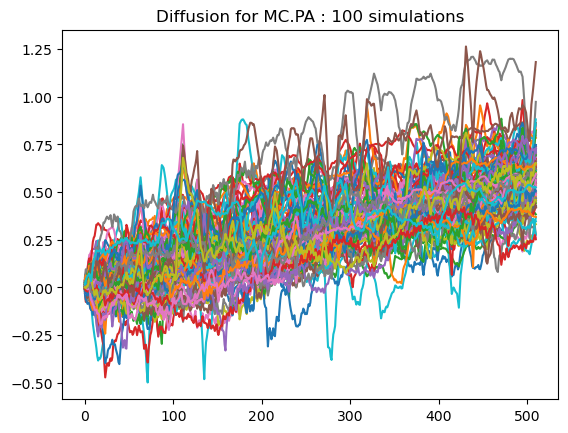

In [38]:
samples_prices, samples_returns, samples_cumsum_returns = simul_with_VAE(conv_vae_model, bivariate_scaler)

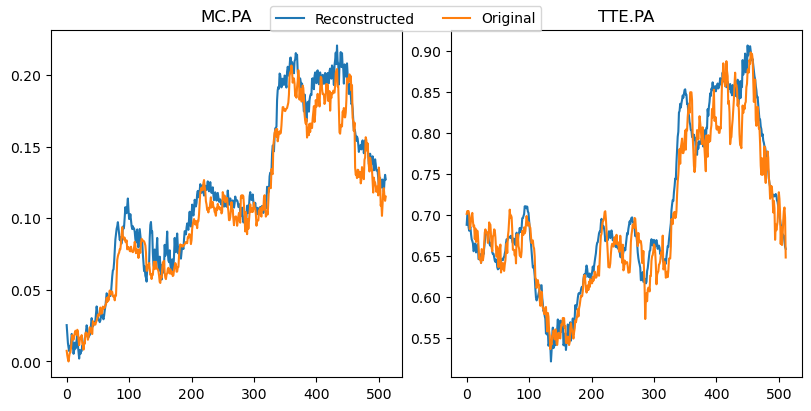

In [35]:
conv_vae_model.eval()
MAE_conv_bi, MAPE_conv_bi, RMSE_conv_bi, AD_conv_bi, KE_conv_bi, to_rec, rec = get_metrics(conv_vae_model, 
                                                                                bivariate_data[:sequence_size], 
                                                                                bivariate_scaler,
                                                                                plot_rec=True)

<AxesSubplot:title={'center':'ConvVAE reconstructed Log Returns TotalEnergies'}>

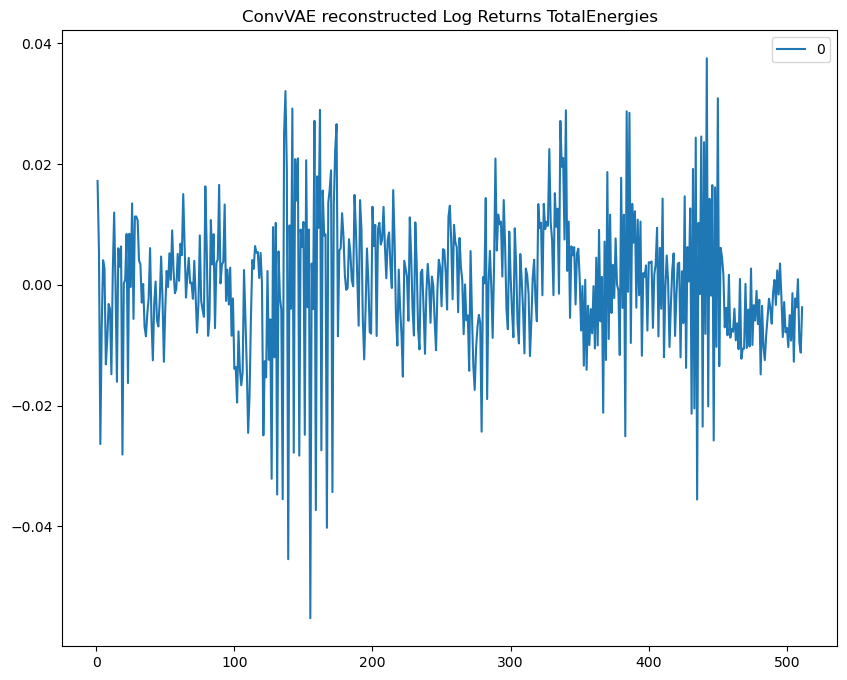

In [60]:
get_returns(pd.DataFrame(rec[:,1]))[1:].plot(figsize=(10, 8), title = "ConvVAE reconstructed Log Returns TotalEnergies")

### Reconstruction comparison

- MAE
- MAPE
- RMSE
- KLD
- KE

**Dense VAE univariate**

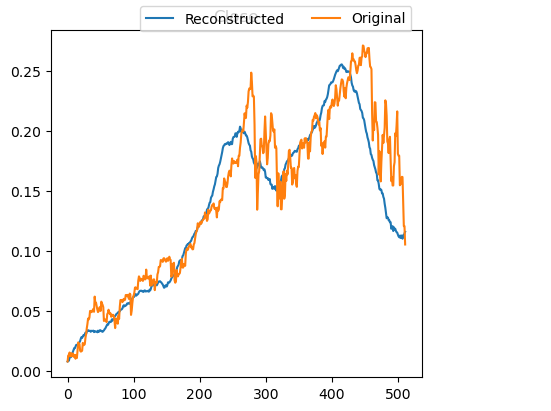

In [88]:
MAE_dense_uni, MAPE_dense_uni, RMSE_dense_uni, AD_dense_uni, KE_dense_uni, _, _ = get_metrics(uni_dense_vae_model, 
                                                                                        univariate_data[:sequence_size], 
                                                                                        univariate_scaler,
                                                                                        plot_rec=True)

In [89]:
dense_uni_metrics = [
    ("MAE", MAE_dense_uni),
    ("MAPE", MAPE_dense_uni),
    ("RMSE", RMSE_dense_uni),
    ("AD", AD_dense_uni),
    ("KE", KE_dense_uni)
]

**Dense VAE bivariate**

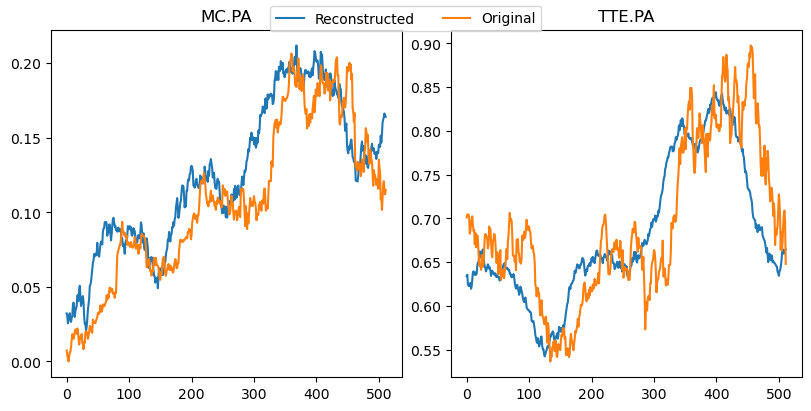

In [90]:
MAE_dense_bi, MAPE_dense_bi, RMSE_dense_bi, AD_dense_bi, KE_dense_bi, _, _ = get_metrics(bi_dense_vae_model, 
                                                                                    bivariate_data[:sequence_size], 
                                                                                    bivariate_scaler,
                                                                                    plot_rec=True)

In [91]:
dense_bi_metrics = [
    ("MAE", MAE_dense_bi),
    ("MAPE", MAPE_dense_bi),
    ("RMSE", RMSE_dense_bi),
    ("AD", AD_dense_bi),
    ("KE", KE_dense_bi)
]

**Convolutional VAE**

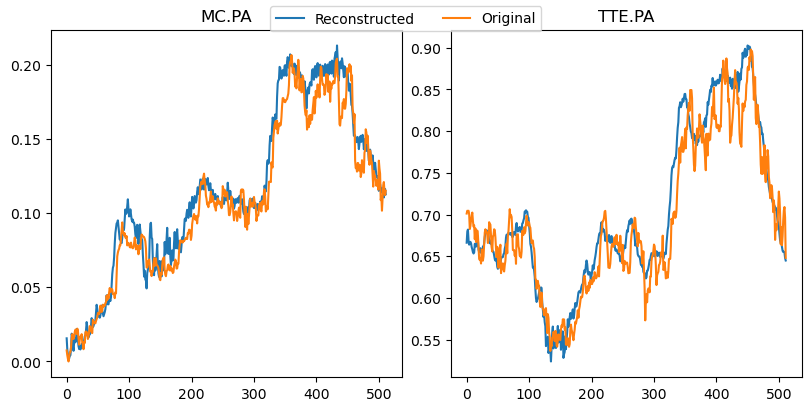

In [103]:
MAE_conv_bi, MAPE_conv_bi, RMSE_conv_bi, AD_conv_bi, KE_conv_bi, _, _ = get_metrics(conv_vae_model, 
                                                                                bivariate_data[:sequence_size], 
                                                                                bivariate_scaler,
                                                                                plot_rec=True)
conv_metrics = [
    ("MAE", MAE_conv_bi),
    ("MAPE", MAPE_conv_bi),
    ("RMSE", RMSE_conv_bi),
    ("AD", AD_conv_bi),
    ("KE" ,KE_conv_bi)
]

In [104]:
conv_metrics

[('MAE', 0.01712617),
 ('MAPE', 7.702909409999847),
 ('RMSE', 0.02327036),
 ('AD', 1.8274450512575928),
 ('KE', 0.019928754892367905)]

### TimeVAE (from Abhyuday Desai)

**TimeVAE Bivariate**

In [ ]:
# Converting dataset to usuable sequences in tensorflow
full_train_data = np.asarray([sequences[i][0].numpy() for i in range(len(sequences))])
full_train_data_uni = np.asarray([univariate_sequences[i][0].squeeze().numpy()[:,None] for i in range(len(univariate_sequences))])

In [112]:
import os, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
warnings.filterwarnings('ignore') 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disabling gpu usage because my cuda is corrupted, needs to be fixed. 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from timeVAE import VariationalAutoencoderConvInterpretable as TimeVAE
import utils2

In [53]:
valid_perc = 0.2

N, T, D = full_train_data.shape   
print('data shape:', N, T, D) 

# ----------------------------------------------------------------------------------
# further split the training data into train and validation set - same thing done in forecasting task
N_train = int(N * (1 - valid_perc))
N_valid = N - N_train

# Shuffle data
np.random.shuffle(full_train_data)

train_data = full_train_data[:N_train]
valid_data = full_train_data[N_train:]   
print("train/valid shapes: ", train_data.shape, valid_data.shape)    


data shape: 1081 512 2
train/valid shapes:  (864, 512, 2) (217, 512, 2)


In [54]:
# ----------------------------------------------------------------------------------
# min max scale the data    
scaler = utils2.MinMaxScaler()        
scaled_train_data = scaler.fit_transform(train_data)

scaled_valid_data = scaler.transform(valid_data)
# joblib.dump(scaler, 'scaler.save')  

# ----------------------------------------------------------------------------------
# instantiate the model     

latent_dim = 8

vae = TimeVAE( seq_len=T,  feat_dim = D, latent_dim = latent_dim, hidden_layer_sizes=[50, 100, 200],        #[80, 200, 250] 
            reconstruction_wt = 3.0,
            # ---------------------
            # disable following three arguments to use the model as TimeVAE_Base. Enabling will convert to Interpretable version.
            # Also set use_residual_conn= False if you want to only have interpretable components, and no residual (non-interpretable) component. 

            # trend_poly=2, 
            # custom_seas = [ (6,1), (7, 1), (8,1), (9,1)] ,     # list of tuples of (num_of_seasons, len_per_season)
            # use_scaler = True,

            #---------------------------
            use_residual_conn = True
        )   



vae.compile(optimizer=Adam())
# vae.summary() ; sys.exit()

early_stop_loss = 'loss'
early_stop_callback = EarlyStopping(monitor=early_stop_loss, min_delta = 1e-1, patience=10) 
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)

In [55]:
vae.fit(
    scaled_train_data, 
    batch_size = 32,
    epochs=500,
    shuffle = True,
    callbacks=[early_stop_callback, reduceLR],
    verbose = 1
)

Epoch 1/500
27/27 [==============================] - 6s 9ms/step - loss: 33278.4867 - reconstruction_loss: 5254.7344 - kl_loss: 840.8785 - lr: 0.0010
Epoch 2/500
27/27 [==============================] - 0s 9ms/step - loss: 6529.3717 - reconstruction_loss: 2009.4110 - kl_loss: 410.8489 - lr: 0.0010
Epoch 3/500
27/27 [==============================] - 0s 12ms/step - loss: 4857.6179 - reconstruction_loss: 1158.3959 - kl_loss: 466.3474 - lr: 0.0010
Epoch 4/500
27/27 [==============================] - 0s 11ms/step - loss: 2679.6490 - reconstruction_loss: 692.9069 - kl_loss: 462.8860 - lr: 0.0010
Epoch 5/500
27/27 [==============================] - 0s 8ms/step - loss: 2039.3529 - reconstruction_loss: 528.8568 - kl_loss: 378.4632 - lr: 0.0010
Epoch 6/500
27/27 [==============================] - 0s 8ms/step - loss: 1707.2130 - reconstruction_loss: 418.6734 - kl_loss: 392.6599 - lr: 0.0010
Epoch 7/500
27/27 [==============================] - 0s 8ms/step - loss: 1518.7710 - reconstruction_loss: 

In [56]:
# ----------------------------------------------------------------------------------
# visually check reconstruction 
X = scaled_train_data

x_decoded = vae.predict(scaled_train_data)
print('x_decoded.shape', x_decoded.shape)

27/27 [==============================] - 0s 3ms/step
x_decoded.shape (864, 512, 2)


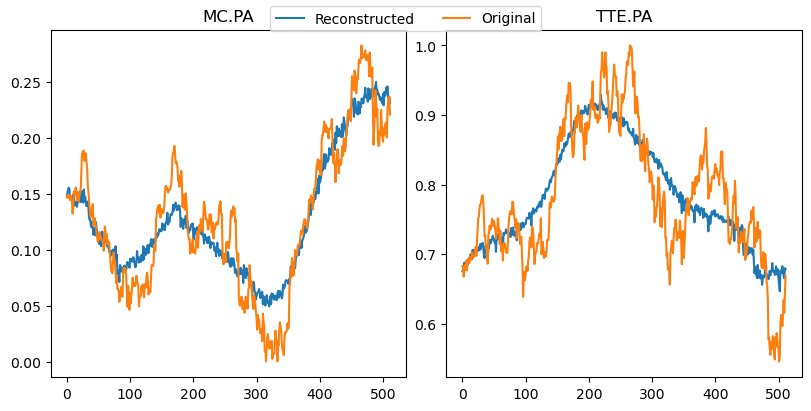

In [57]:
# Manually do the metrics stuff for the tensorflow original timeVAE
to_reconstruct = scaled_train_data[0]
reconstructed_data = x_decoded[0]

plot_reconstruction(reconstructed_data, to_reconstruct, bivariate_scaler)

<AxesSubplot:title={'center':'TimeVAE reconstructed Log Returns TotalEnergies'}>

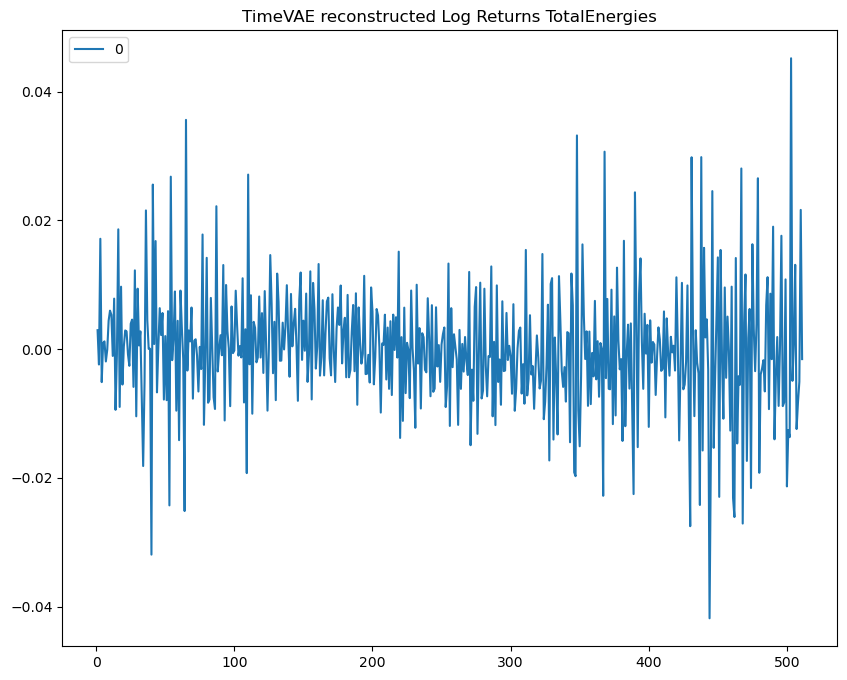

In [59]:
get_returns(pd.DataFrame(reconstructed_data[:,1]))[1:].plot(figsize=(10, 8), title = "TimeVAE reconstructed Log Returns TotalEnergies")

In [107]:
def mae(pred, y):
    error = pred - y
    return np.abs(error).mean()

def mape(pred, y):
    error = pred - y
    return np.abs(error / y).mean() * 100

def rmse(pred, y):
    error = pred - y
    return np.sqrt(np.square(error).mean())

MAPE_timeVAE = mape(to_reconstruct, reconstructed_data)
RMSE_timeVAE = rmse(to_reconstruct, reconstructed_data)
MAE_timeVAE = mean_absolute_error(to_reconstruct, reconstructed_data)
AD_timeVAE = anderson_ksamp([to_reconstruct.flatten(), reconstructed_data.flatten()]).statistic

if to_reconstruct.shape[1]>=2:
    KE_timeVAE = kendall_evaluation(to_reconstruct, reconstructed_data)

In [108]:
timeVAE_bi_metrics = [
    ("MAE", MAE_timeVAE),
    ("MAPE", MAPE_timeVAE),
    ("RMSE", RMSE_timeVAE),
    ("AD", AD_timeVAE),
    ("KE", KE_timeVAE)
]

In [109]:
timeVAE_bi_metrics

[('MAE', 0.031846218),
 ('MAPE', 12.970155477523804),
 ('RMSE', 0.04112284),
 ('AD', 6.842167599163815),
 ('KE', 0.08181338674168298)]

**TimeVAE Univariate**

In [113]:
valid_perc = 0.2

N, T, D = full_train_data_uni.shape   
print('data shape:', N, T, D) 

# ----------------------------------------------------------------------------------
# further split the training data into train and validation set - same thing done in forecasting task
N_train = int(N * (1 - valid_perc))
N_valid = N - N_train

# Shuffle data
np.random.shuffle(full_train_data_uni)

train_data = full_train_data_uni[:N_train]
valid_data = full_train_data_uni[N_train:]   
print("train/valid shapes: ", train_data.shape, valid_data.shape)

# ----------------------------------------------------------------------------------
# min max scale the data    
scaler = utils2.MinMaxScaler()        
scaled_train_data = scaler.fit_transform(train_data)

scaled_valid_data = scaler.transform(valid_data)
# joblib.dump(scaler, 'scaler.save')  

# ----------------------------------------------------------------------------------
# instantiate the model     

latent_dim = 8

vae = TimeVAE( seq_len=T,  feat_dim = D, latent_dim = latent_dim, hidden_layer_sizes=[50, 100, 200],        #[80, 200, 250] 
            reconstruction_wt = 3.0,
            # ---------------------
            # disable following three arguments to use the model as TimeVAE_Base. Enabling will convert to Interpretable version.
            # Also set use_residual_conn= False if you want to only have interpretable components, and no residual (non-interpretable) component. 

            # trend_poly=2, 
            # custom_seas = [ (6,1), (7, 1), (8,1), (9,1)] ,     # list of tuples of (num_of_seasons, len_per_season)
            # use_scaler = True,

            #---------------------------
            use_residual_conn = True
        )   



vae.compile(optimizer=Adam())
# vae.summary() ; sys.exit()

early_stop_loss = 'loss'
early_stop_callback = EarlyStopping(monitor=early_stop_loss, min_delta = 1e-1, patience=10) 
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)

vae.fit(
    scaled_train_data, 
    batch_size = 32,
    epochs=500,
    shuffle = True,
    callbacks=[early_stop_callback, reduceLR],
    verbose = 1
)

data shape: 1080 512 1
train/valid shapes:  (864, 512, 1) (216, 512, 1)
Epoch 1/500
27/27 [==============================] - 4s 9ms/step - loss: 23506.9146 - reconstruction_loss: 4555.3130 - kl_loss: 224.7138 - lr: 0.0010
Epoch 2/500
27/27 [==============================] - 0s 8ms/step - loss: 2443.6731 - reconstruction_loss: 570.0840 - kl_loss: 481.7491 - lr: 0.0010
Epoch 3/500
27/27 [==============================] - 0s 8ms/step - loss: 1731.9814 - reconstruction_loss: 450.7171 - kl_loss: 401.1985 - lr: 0.0010
Epoch 4/500
27/27 [==============================] - 0s 8ms/step - loss: 1731.2083 - reconstruction_loss: 444.7101 - kl_loss: 336.0288 - lr: 0.0010
Epoch 5/500
27/27 [==============================] - 0s 8ms/step - loss: 1610.3943 - reconstruction_loss: 426.4676 - kl_loss: 370.2736 - lr: 0.0010
Epoch 6/500
27/27 [==============================] - 0s 8ms/step - loss: 1592.2566 - reconstruction_loss: 403.3617 - kl_loss: 337.8877 - lr: 0.0010
Epoch 7/500
27/27 [===================

In [114]:
# ----------------------------------------------------------------------------------
# visually check reconstruction 
X = scaled_train_data

x_decoded = vae.predict(scaled_train_data)
print('x_decoded.shape', x_decoded.shape)

27/27 [==============================] - 0s 4ms/step
x_decoded.shape (864, 512, 1)


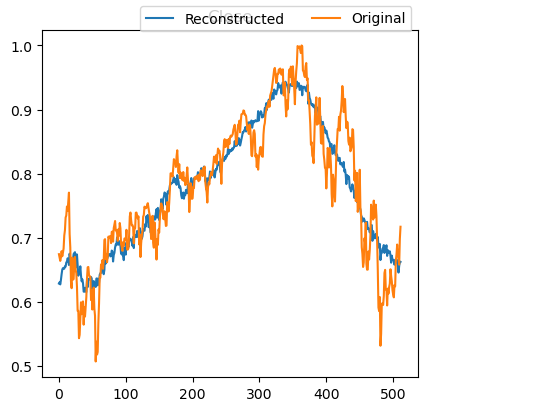

In [115]:
# Manually do the metrics stuff for the tensorflow original timeVAE
to_reconstruct = scaled_train_data[0]
reconstructed_data = x_decoded[0]

plot_reconstruction(reconstructed_data, to_reconstruct, univariate_scaler)

<AxesSubplot:title={'center':'Reconstructed Log Returns'}>

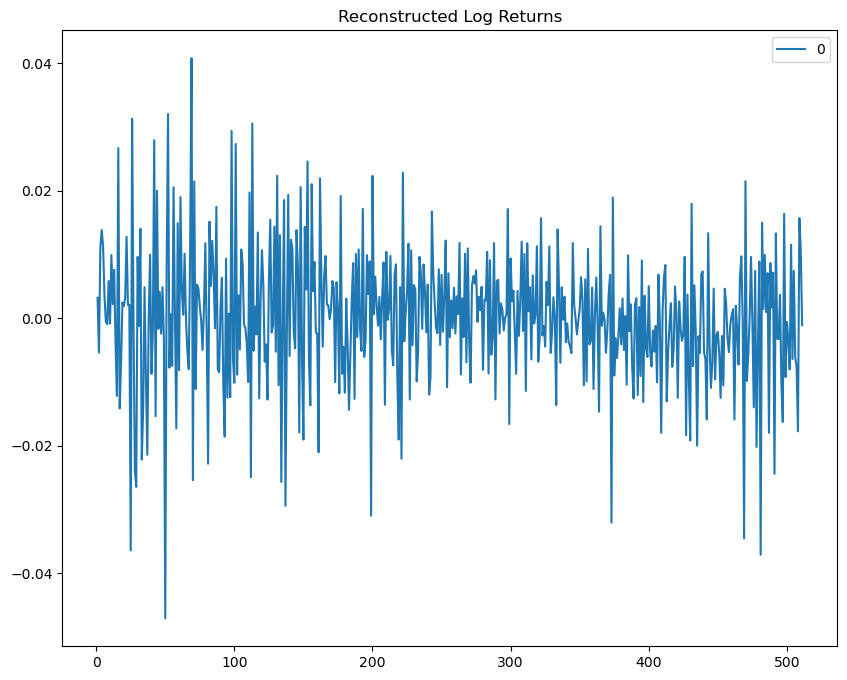

In [116]:
get_returns(pd.DataFrame(reconstructed_data))[1:].plot(figsize=(10, 8), title = "Reconstructed Log Returns")

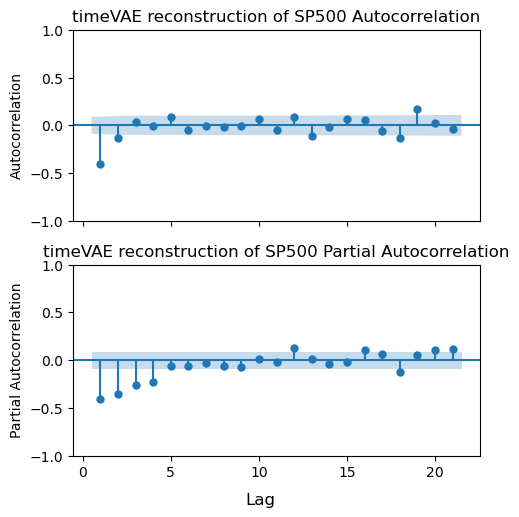

In [53]:
plot_acf_pacf(get_returns(pd.DataFrame(reconstructed_data))[1:], "timeVAE reconstruction of SP500")

In [117]:
MAPE_timeVAE_uni = mape(to_reconstruct, reconstructed_data)
RMSE_timeVAE_uni = rmse(to_reconstruct, reconstructed_data)
MAE_timeVAE_uni = mean_absolute_error(to_reconstruct, reconstructed_data)
AD_timeVAE_uni = anderson_ksamp([to_reconstruct.flatten(), reconstructed_data.flatten()]).statistic

KE_timeVAE_uni=None
if to_reconstruct.shape[1]>=2:
    KE_timeVAE_uni = kendall_evaluation(to_reconstruct, reconstructed_data)

timeVAE_uni_metrics = [
    ("MAE", MAE_timeVAE_uni),
    ("MAPE", MAPE_timeVAE_uni),
    ("RMSE", RMSE_timeVAE_uni),
    ("AD", AD_timeVAE_uni),
    ("KE", KE_timeVAE_uni)
]

# CONCLUSION

In [118]:
# Create DataFrames for each metrics list
df1 = pd.DataFrame(dense_uni_metrics, columns=["Metric", "denseVAE univar"]).set_index("Metric")
df2 = pd.DataFrame(timeVAE_uni_metrics, columns=["Metric", "timeVAE univar"]).set_index("Metric")

df3 = pd.DataFrame(dense_bi_metrics, columns=["Metric", "denseVAE bivar"]).set_index("Metric")
df4 = pd.DataFrame(conv_metrics, columns=["Metric", "convVAE bivar"]).set_index("Metric")
df5 = pd.DataFrame(timeVAE_bi_metrics, columns=["Metric", "timeVAE bivar"]).set_index("Metric")

# Merge the DataFrames
metrics_df = pd.concat([df1, df2, df3,  df4, df5], axis=1).T

In [119]:
metrics_df.round(4)

Metric              MAE     MAPE    RMSE      AD      KE
denseVAE univar  0.0196  17.2545  0.0272  2.6560  0.0000
timeVAE univar   0.0317   4.1913  0.0412  3.8553     NaN
denseVAE bivar   0.0341  14.1170  0.0457  8.9864  0.0514
convVAE bivar    0.0171   7.7029  0.0233  1.8274  0.0199
timeVAE bivar    0.0318  12.9702  0.0411  6.8422  0.0818